# Building a deep learning model from scractch for non linear classification problem
 
There are four steps to build and use a machine learning model.

- **Preprocessing** : feature selection, ramdomize, normalize, shuffle, EDA, split train test
- **Learning** : implementing the model
- **Evaluation** : metrics ( true positive, false positive...etc), tests, overfitting undertitting, hyper tunnin
- **Prediction** on new unseen data

## Problem context

You will implement a deep learning model to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

## 1 -  Preprocessing et EDA

La première étape consiste à charger puis visualizer puis analyser les données

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#fonction utilitaire pour afficher les points

def plot_points(X, y):
    sns.scatterplot(X[:, 0], X[:, 1], hue=y.flatten(), cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    plt.show()
    
# fonction utilitaire pour randomiser les données (shuffle)
def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation,:]
    Y2 = Y[permutation]
    Y2[Y2 == -1] = 0 
    return X2, Y2  

# fonction utilitaire pour split les données en test et train sets
def split_train_test(data, test_size):
    sample = np.random.choice(data.index, size=int(len(data)*(1 - test_size)), replace=False)
    train_data, test_data = data.iloc[sample], data.drop(sample)
    return train_data, test_data 

### Load data

In [2]:
data = pd.read_csv('microships_QA.csv');
data.head()

,test1,test2,result
0,0.336494,-0.985951,-1.0
1,-0.011043,-0.105529,1.0
2,0.238160,-0.617417,1.0
3,-0.366783,-0.713819,1.0
4,1.221923,-1.039399,-1.0


### Split data into train and test sets

In order to test our algorithm, we'll split the data into a Training and a Testing set.

In [3]:
train_data, test_data = split_train_test(data, test_size=0.1)

### Extract features and target columns

In [4]:
X_train = np.array(train_data.drop('result', axis=1))
y_train = np.array(train_data['result']).reshape(-1, 1)
X_test = np.array(test_data.drop('result', axis=1))
y_test = np.array(test_data['result']).reshape(-1, 1)

print("Shape of X_train = ", X_train.shape, "Shape of y_train=", y_train.shape, "\n")
print("Shape of X_test = ",  X_test.shape, "Shape of y_test =",  y_test.shape, "\n")

Shape of X_train =  (90, 2) Shape of y_train= (90, 1) 

Shape of X_test =  (10, 2) Shape of y_test = (10, 1) 



### Randomize features and target columns

In [5]:
X_train, y_train = randomize(X_train, y_train)
X_test, y_test = randomize(X_test, y_test)

### Visualize dataset

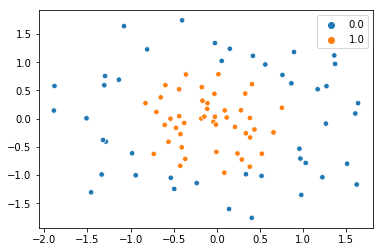

In [6]:
plot_points(X_train, y_train)

## 2 -  Implementing the deep learning model 

###  Sigmoid
**In order to learn using gradient descent** error function has to be continuous and differentiable.
- Sigmoid function gives not discrete value but probability of being a value (probabilty space). Sigmoid activation function is used when we have 2 labels. 

$$sigmoid(x) = \frac{1}{1+e^{-x}}$$

In [7]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def sigmoid_prime(X):
    return sigmoid(X) * (1 - sigmoid(X))

### Loss Function

We will use MSA = MEAN SQUARED ERROR

It is easier to actually optimize on MSE, as the a quadratic term is differentiable. This factor makes this metric better for gradient based optimization algorithms.

$$E = \frac{1}{2 N} \sum (y_p -y_t)^2 $$

Derivative of Mean Squared Error 

$$
\frac{\partial E}{\partial w_j} = -\frac{1}{N}\sum_{n=1}^N x_{nj}(y_n - (Xw)_n) = -\frac{1}{N}x_j^T (y - Xw),
$$

Weight error 

$$
\nabla E(w) = -\frac{1}{N}X^T (y - Xw)
$$

In [8]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

### Layer
A layer in neural networks contains a set neurons and has two methods: forward_prog and backward_prog

In [9]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

**Now let us implement a fully connected layer**

- Output (prediction) formula

$$\hat{y} = activate(input * w + b) =  \sigma(w_1 x_1 + w_2 x_2 + b)$$

- Backpropagation

$$ w_i \longrightarrow w_i - \alpha \frac{dE}{dw_i}$$

$$ b \longrightarrow b - \alpha \frac{dE}{db}$$


<img src="https://user.oc-static.com/upload/2017/10/21/15085704733297_P2C1-4.png">

In [10]:
class FullyConnectedLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * dBias
        return input_error

In [11]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

### Now we have all the elements to implement a neural network

In [13]:
class NeuralNetwork:
    def __init__(self, loss, loss_prime):
        self.layers = [] 
        self.loss = loss
        self.loss_prime = loss_prime
        self.errors = []

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # train the network using the gradient descent algorithm
    def train(self, x_train, y_train, epochs, learning_rate):
        
        # transform to tensor (3 dimensions matrix)
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])
        
        # sample dimension first
        samples = len(x_train)
        # training loop
        for epoch in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                  
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            
            self.errors.append(err)
            
            if (epoch % 100 == 0):
                print('epoch %d/%d   error=%f' % (epoch, epochs, err))
            
    # predict output for given input
    def predict(self, input_data, threshold = 0.5):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return (np.asarray(result) > threshold).astype(int).flatten()

### Train the neural network

<img src="https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_schematic.png">

epoch 0/1000   error=0.249158
epoch 100/1000   error=0.247883
epoch 200/1000   error=0.247883
epoch 300/1000   error=0.247883
epoch 400/1000   error=0.247883
epoch 500/1000   error=0.247883
epoch 600/1000   error=0.247883
epoch 700/1000   error=0.247883
epoch 800/1000   error=0.247883
epoch 900/1000   error=0.247883


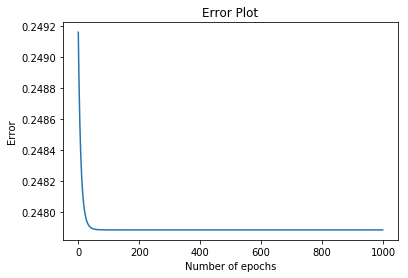

In [18]:
net = NeuralNetwork(mse, mse_prime)

net.add(FullyConnectedLayer(2, 1))
net.add(ActivationLayer(sigmoid, sigmoid_prime))

net.train(X_train, y_train, epochs=1000, learning_rate=0.01)

# Plotting the error
plt.title("Error Plot")
plt.xlabel('Number of epochs')
plt.ylabel('Error')
plt.plot(net.errors)
plt.show()

## 3 -  Evaluate 

Once we've trained our neural network, we need to evaluate our model on test data: accuracy, false positive, true positive

In [15]:
# fonction utilitaire pour afficher l'accuracy de notre model deep learning
def print_accuracy() : 
    predictions = net.predict(X_test, threshold = 0.5)
    accuracy = np.multiply(np.mean((predictions == y_test.flatten()).astype(int)), 100)
    print("Accuracy: {:.3f}%".format(accuracy))
    
# fonction utilitaire pour generer un grid 2-D de coordonnées 
# c'est une façon d'échantillonner une fonction sur une grille rectangulaire, 
# ça aide à visualiser la fonction comme une "image".

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

# cette fonction permet de visualiser la limite de descision de notre model
def plot_descision_boundary(estimator, X, y):
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    target = np.c_[xx.ravel(), yy.ravel()]
    Z = estimator.predict(target)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
    sns.scatterplot(X0, X1, hue=y.flatten(), cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    plt.show()    

In [19]:
print_accuracy()

Accuracy: 50.000%


**Plot the descision boundary to get a visualization of what our neural networks have learned.**

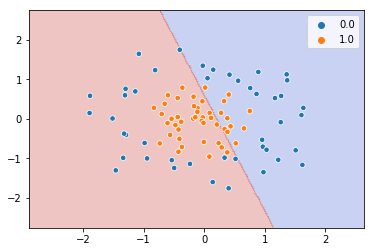

In [20]:
plot_descision_boundary(net, X_train, y_train)

## 4 -  Predict on new unseen data

In [21]:
net.predict(np.array([[-2, -1]]))

array([1])

On constate qu'un réseau de neurones avec un seul neuronne ne peut apprendre qu'une fonction lineaire W * X +b
Donc résoudre notre problème de classification il faut que notre reseau de neurones apprenne une fonction non lineaire et pour faire cela on va combiner le resultat de plusieurs neuronnes ensemble.


<img src="imgs/neural_network_non_linear.png" />

epoch 0/1000   error=0.256491
epoch 100/1000   error=0.213139
epoch 200/1000   error=0.131095
epoch 300/1000   error=0.129076
epoch 400/1000   error=0.127376
epoch 500/1000   error=0.126107
epoch 600/1000   error=0.125524
epoch 700/1000   error=0.125081
epoch 800/1000   error=0.124713
epoch 900/1000   error=0.124395


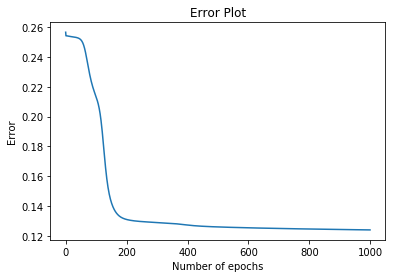

In [22]:
net = NeuralNetwork(mse, mse_prime)

net.add(FullyConnectedLayer(2, 2))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FullyConnectedLayer(2, 1))
net.add(ActivationLayer(sigmoid, sigmoid_prime))

net.train(X_train, y_train, epochs=1000, learning_rate=0.1)

# Plotting the error
plt.title("Error Plot")
plt.xlabel('Number of epochs')
plt.ylabel('Error')
plt.plot(net.errors)
plt.show()

In [23]:
print_accuracy()

Accuracy: 80.000%


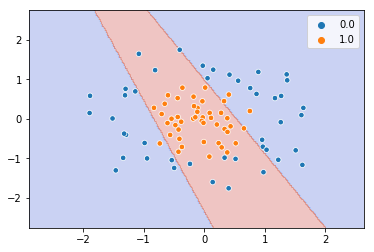

In [24]:
plot_descision_boundary(net, X_train, y_train)

**On commence à apprendre des fonctions non linéaire mais on est encore loin du résultat attendu. On a joute donc encore plus de neurones.**

<img src="imgs/neural_network_multi_dim.png" />

epoch 0/1000   error=0.262849
epoch 100/1000   error=0.065558
epoch 200/1000   error=0.033259
epoch 300/1000   error=0.023423
epoch 400/1000   error=0.016931
epoch 500/1000   error=0.012196
epoch 600/1000   error=0.008976
epoch 700/1000   error=0.006968
epoch 800/1000   error=0.005719
epoch 900/1000   error=0.004861


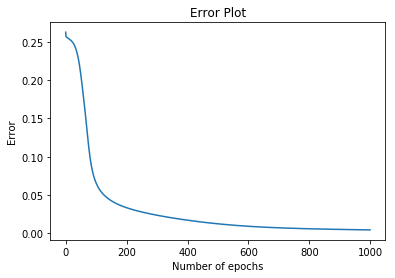

In [25]:
net = NeuralNetwork(mse, mse_prime)

net.add(FullyConnectedLayer(2, 10))
net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.add(FullyConnectedLayer(10, 1))
net.add(ActivationLayer(sigmoid, sigmoid_prime))

net.train(X_train, y_train, epochs=1000, learning_rate=0.1)

# Plotting the error
plt.title("Error Plot")
plt.xlabel('Number of epochs')
plt.ylabel('Error')
plt.plot(net.errors)
plt.show()

In [26]:
print_accuracy()

Accuracy: 100.000%


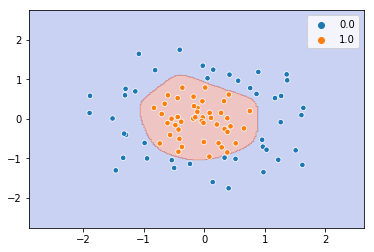

In [27]:
plot_descision_boundary(net, X_train, y_train)

# Bravo ! End of lab deep learning from scratch